<a href="https://colab.research.google.com/github/austinpeel/jax-strong-lensing/blob/dev-egor/GRF_phase_averaged_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Folder='/content/drive/My Drive/Jax_Strong_Lensing/'

import sys
sys.path.append(Folder+'/Modules')
_=!python drive/My\ Drive/Jax_Strong_Lensing/Modules/My_repo/setup.py install

Mounted at /content/drive


In [2]:
_=!pip install pyFFTW
_=!pip install powerbox

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer

#My utils
from jaxtronomy.GaussianRandomField.GRF_model import Potential_based_GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.GRF_model import GRF_perturbed_lens
from jaxtronomy.GaussianRandomField.Lens_Source_model import Lens_Source_model

#GRF generator
import powerbox as pbox

# Universal font size
FS = 18

# Theory

Assume that we have GRF perturbed strong lensing event. First, we want to model it without GRF perturbations and consider the residuals.

## Data

simulation: $\psi(\vec{p}_{0})+\delta \psi(A_{0},\beta_{0},\phi_{0})$  
model 1: $\psi(\vec{p_1})$  
$res_{0}=\delta \psi(A_{0},\beta_{0},\phi_{0})+\psi(\vec{p}_{0})-\psi(\vec{p_1})$

,where $\vec{p}$ is a set of source light and unperturbed lens mass parameters and $A_{0},\beta_{0},\phi_{0}$ are correpsondingly amplitude,power slope and phase realisation of GRF power spectrum. Index 0 would refer to true values or zeroth aproximation.

## Model

mock: $\psi(\vec{p}_{1})+\delta \psi(A^{i},\beta^{j},\phi^{m})$  
model 2: $\psi(\vec{p_2})$  
$res^{i,j,m}_{1}=\delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2})$

,where we assume that $\psi(\vec{p}_{1})$ is close to $\psi(\vec{p}_{0})$, and try to pick a realisation of GRF perturbation $\delta \psi(A^{i},\beta^{j},\phi^{m})$

## Power spectra and Loss function

Since Gaussian Random Field is defined by its Power Spectrum  
$PS\{\delta \psi(A_{0},\beta_{0},\phi_{0})\}=|FFT\{\delta \psi(A_{0},\beta_{0},\phi_{0})\}|^{2}=A_0 \cdot k^{-\beta_0}$

We further want to create loss in terms of residuals power spectra.
The problem here is that a particular realisation of phase $\phi_0$ is a big array that we don't want to fit. Rather we would take M realisations of phase $\phi_m$ and average the corresponding power spectra over phase realisations. In this case we concern ourselves only with interesting parameters $A_i$ and $\beta_j$ by excluding phase $\phi_m$ out of the equations.

In this case the loss function would be as follows:
$\mathcal{L}^{ij}=|| \ PS\{res_{0}\} - <PS\{res^{i,j,m}_{1}\}>_m \ ||$

## Model absorbtion function

Of course some effect of $\delta \psi(A_{0},\beta_{0},\phi_{0})$ would be absorbed into $\psi(\vec{p_1})$ as well as some effect of $\delta \psi(A^{i},\beta^{j},\phi^{m})$ would be absorbed into $\psi(\vec{p_2})$. To work with this absorbtion we can introduce model absorbtion function:  

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0},\phi_{0})$  
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0},\phi_{0}),A^{i},\beta^{j},\phi^{m})$








## Hypotheses




### 1) weak dependence of model absorbtion function on phase $\phi^{m}$

One of the assumptions to be made is that model parameters aggravation should mostly depend on GRF's amplitude $A$ and power slope $\beta$, rather than on phase realisation $\phi$. So we say that impact of phase is small. Let's denote it as:

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0})$   
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m})$




### 2)Big enough number M of phase realisations $\phi^{m}$

Now we can write our mock residual power spectrum in terms of model absorbtion functions.

$PS\{res^{i,j,m}_{1}\}=PS\{ \delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(\vec{p}_{1})-\psi(\vec{p_2})  \}= \\
PS\{ \delta \psi(A^{i},\beta^{j},\phi^{m})+\psi(f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0}))-\psi(f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m}))  \}$

Now if all $\delta f(\phi)$ would be eliminated, the formula would become quite useful. So the second assumption is that the number of phase realisations **M** is enough for the phase averaged power spectrum to not depend on the actual phases realisations, in other words that

$M: \quad  <PS\{res^{i,j,m}_{1}\}>_{m \in [0,M]} \quad \approx  \quad <PS\{res^{i,j,m}_{1}\}>_{m \in [0,\infty]}$

In that case the loss function can be represented as 

$\mathcal{L}^{ij}=|| \ PS[A_0,\beta_0,\vec{p},f(\vec{p},A_{0},\beta_{0})] - PS[A_0,\beta_0,f(\vec{p},A_{0},\beta_{0}),f(f(\vec{p},A_{0},\beta_{0}),A^{i},\beta^{j})] \ ||$

If we assume that the fitted values are close to the true onse we can expect the loss function to be 

$\mathcal{L}^{ij}=|| \ O[A_0 - A^i] + O[\beta_0 -\beta^j] + O[\vec{p}-f(\vec{p},A_{0},\beta_{0})]+ O[f(\vec{p},A_{0},\beta_{0})-f(f(\vec{p},A_{0},\beta_{0}),A^{i},\beta^{j})] \ ||+...$

The assumption that the fitted values are close to the true ones if GRF impact on the system is very small. In other words, if we work in perturbation theory

$\mathcal{L}^{ij}=|| \  O[A_0 - A^i] + O[\beta_0 -\beta^j] + O[\frac{\delta \psi(A_{0},\beta_{0},\phi_{0})}{\psi(\vec{p})}]+ O[\frac{\delta \psi(A^{i},\beta^{j},\phi^{m})}{\psi(\vec{p_1})}] \ ||+...$




### 3) Convergence of $\mathcal{L}^{ij}$ forces convergence of $A^i \rightarrow A_0, \beta^j \rightarrow \beta_0$

consider convergence loss and model absorbtion loss  
$\mathcal{L}_{conv}=|| \  O[A_0 - A^i] + O[\beta_0 -\beta^j] \ ||$  
$\mathcal{L}_{abs}=|| \  O[\frac{\delta \psi(A_{0},\beta_{0},\phi_{0})}{\psi(\vec{p})}]+ O[\frac{\delta \psi(A^{i},\beta^{j},\phi^{m})}{\psi(\vec{p_1})}] \ ||$

So here we want to find that either absorbtion loss is neglegible
$\mathcal{L}_{conv} \gg \mathcal{L}_{abs}$  
or that both losses converge simultaniously  
$\mathcal{L}^{ij} \rightarrow 0$ => $\mathcal{L}_{conv}^2 + \mathcal{L}_{abs}^2 \rightarrow 0 $






# Simulation parameters and fitting functions

In [8]:
kwargs_lens_mass_array=[{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                       {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

kwargs_source_light_array=[{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]


#Number of phases realisations
M=10

#Class for GRF hadnling
GRF_class=Potential_based_GRF_perturbed_lens(kwargs_lens_mass_array=kwargs_lens_mass_array,\
                                             kwargs_source_light_array=kwargs_source_light_array)

WARNING! sigma_b*f 0 < 1 count may introduce unstable error estimates with a Gaussian error function for a Poisson distribution with mean < 1.


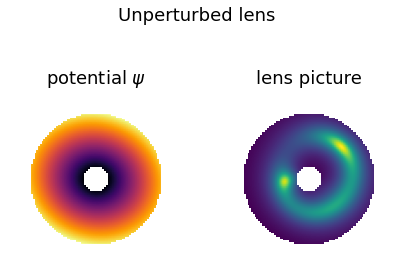

In [9]:
#Data grid
pixel_grid = PixelGrid(**GRF_class.Lens_Source_model.kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates


#Since SIE characterisitics diverge in the center we compute everything in the masked region
# Generate a mask
rmin = 0.5
rmax = 3
# High-res grid
radius = np.hypot(xgrid, ygrid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#Account for variance only in the masked region impacting the source's light
unperturbed_potential=deepcopy(np.array(GRF_class.get_total_potential(include_GRF=False)))
unperturbed_potential[~mask]=np.nan
unpert_potential_variance=np.nanstd(unperturbed_potential)**2

lens_picture=np.where(mask,GRF_class.get_lens_picture(picture_type='model',include_GRF=False),np.nan)

fig,ax=plt.subplots(1,2,figsize=(7,5))
ax[0].imshow(unperturbed_potential,cmap='inferno', origin='lower')
ax[1].imshow(lens_picture,origin='lower')

unpert_fig_titles=[r"potential $\psi$",'lens picture']
for i in range(2):
  ax[i].axis('off')
  ax[i].set_title(unpert_fig_titles[i], fontsize=FS)

fig.suptitle('Unperturbed lens',fontsize=FS)
plt.show()

In [10]:
  psf = PSF(**GRF_class.Lens_Source_model.kwargs_psf)

  noise = Noise(GRF_class.Lens_Source_model.kwargs_pixel['nx'], GRF_class.Lens_Source_model.kwargs_pixel['ny'], **GRF_class.Lens_Source_model.kwargs_noise)

  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=PixelGrid(**GRF_class.Lens_Source_model.kwargs_pixel),
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(GRF_class.Lens_Source_model.lens_mass_model_list[:-1]),
                         source_model_class=LightModel(GRF_class.Lens_Source_model.source_light_model_list),
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=list(GRF_class.Lens_Source_model.kwargs_lens_mass[:-1]),
                             kwargs_source=list(GRF_class.Lens_Source_model.kwargs_source_light),
                             kwargs_lens_light=[{}])

In [11]:
def get_model(Lens_Source_model):

  psf = PSF(**GRF_class.Lens_Source_model.kwargs_psf)

  noise = Noise(Lens_Source_model.kwargs_pixel['nx'], Lens_Source_model.kwargs_pixel['ny'], **GRF_class.Lens_Source_model.kwargs_noise)

  # Generate a lensed image based on source and lens models
  #Source light from simulation
  #Lens mass except for PIXELATED GRF from simulation
  lens_image = LensImage(data_class=PixelGrid(**Lens_Source_model.kwargs_pixel),
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=LensModel(Lens_Source_model.lens_mass_model_list[:-1]),
                         source_model_class=LightModel(Lens_Source_model.source_light_model_list),
                         lens_light_model_class=LightModel([]),
                         kwargs_numerics={'supersampling_factor': 1})
  
  #To calculate noise map for the first time
  _= lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=list(Lens_Source_model.kwargs_lens_mass[:-1]),
                             kwargs_source=list(Lens_Source_model.kwargs_source_light),
                             kwargs_lens_light=[{}])


  kwargs_true = {'kwargs_lens': list(Lens_Source_model.kwargs_lens_mass[:-1]), 'kwargs_source': list(Lens_Source_model.kwargs_source_light)}

  return lens_image,kwargs_true

def get_parameters(Lens_Source_model):

  kwargs_model = {
    'lens_model_list': Lens_Source_model.lens_mass_model_list[:-1],
    'source_model_list': Lens_Source_model.source_light_model_list,
    'lens_light_model_list': [],
  }

  kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},{'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
    'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],
  }


  #Priors from this article Park et al. 2021 Table 1 (Partially)
  '''
  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['gaussian', 1.1, 0.1], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.07], 'center_y': ['gaussian', 0, 0.07]}, {'gamma1': ['uniform', -0.05, 0.05], 'gamma2': ['uniform', -0.05, 0.05]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['gaussian',3,0.5],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  '''

  kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2], \
                     'center_x': ['gaussian', 0, 0.102], 'center_y': ['gaussian', 0, 0.102]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
                  
    'kwargs_source': [{'amp': ['uniform',5.0,20.0], 'R_sersic': ['uniform',1e-3,5.], 'n_sersic': ['uniform',1e-3,4.0],\
                       'center_x': ['uniform', -1.0, 1.0], 'center_y': ['uniform', -1.0, 1.0],'e1': ['gaussian', 0, 0.2], 'e2': ['gaussian', 0, 0.2]}],
  }
  
  kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],  # fix all source parameters
    }

  parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

  return parameters


def fit_data(data,lens_image,parameters):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
  if extra_fields['hess_inv'] is not None:
    fisher_matrix = extra_fields['hess_inv']
  else:
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

  return kwargs_final,fisher_matrix

def get_fit_kwargs_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index):
    lens_image,kwargs_true=get_model(lensing_class)
    parameters=get_parameters(fix_lens_origin=False)
    num_of_params=len(parameters.kwargs2args(kwargs_true))


    kwargs_final_row=[]
    fisher_matrices=np.zeros((len(Potential_beta_array),num_of_params,num_of_params))
    for j,beta in enumerate(Potential_beta_array):
        parameters=get_parameters(fix_lens_origin=False)
        data=potential_perturbed_data[Variance_index,j]

        kwargs_final,fisher_matrix=fit_data(data,lens_image,parameters)
        fisher_matrices[j]=fisher_matrix

        kwargs_final_row+=[kwargs_final]
    
    return np.array(kwargs_final_row),fisher_matrices

def save_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index):
    kwargs_final_row,fisher_matrices=get_fit_kwargs_row(lensing_class,potential_perturbed_data,Potential_beta_array,Variance_index)
    np.save(Folder+'/Data/16x16/Separate_fitting/Kwargs_row_source_lens_%d.npy'%Variance_index,kwargs_final_row)
    np.save(Folder+'/Data/16x16/Separate_fitting/Fisher_matrices_%d.npy'%Variance_index,fisher_matrices)

In [12]:
'''#Create grid of GRF variances and power slopes that aggravate lens with same strength in terms of variance 
def potential_Var_from_residual_Var(residual_variance,beta_array,df_coef):
  q=df_coef.loc['potential_logvariance','Residual coefs']
  p=df_coef.loc['beta','Residual coefs']
  C=df_coef.loc['bias','Residual coefs']
  logVariance=(np.log10(residual_variance)-p*beta_array-C)/q
  return np.power(10,logVariance)

#Relation between impact of GRF on lens, GRF variance and power slope
df_coef=pd.DataFrame(data=[0.,1.0020,-0.2656],index=['bias','potential_logvariance','beta'],columns=['Residual coefs'])
unperturbed_lens_variance=GRF_class.get_lens_picture(picture_type='model').std()**2

Potential_beta_array=np.linspace(2,7,16)


Potential_variance_array=np.zeros(len(Potential_beta_array))
#Lens aggravation image variance is 0.005 of actual lens image variance

for j in enumerate(Potential_beta_array):
  Potential_variance_array=potential_Var_from_residual_Var(np.power(10,-2.5)*unperturbed_lens_variance,Potential_beta_array,df_coef=df_coef)

perturbed_lens_images=np.zeros((len(Potential_variance_array),GRF_class.Lens_Source_model.kwargs_pixel['nx'],GRF_class.Lens_Source_model.kwargs_pixel['ny']))

for i,Variance in enumerate(Potential_variance_array):
  GRF_class.Change_Power_Spectrum(Variance=Potential_variance_array[0],Power_slope=Potential_beta_array[i])
  perturbed_lens_images[i]=GRF_class.get_lens_picture(picture_type='model')


GRF_impact_images=perturbed_lens_images-GRF_class.get_lens_picture(picture_type='model',include_GRF=False)

fig,ax=plt.subplots(2,len(Potential_beta_array),figsize=(30,6))

for i,beta in enumerate(Potential_beta_array):
  img_pert=ax[0,i].imshow(perturbed_lens_images[i],origin='lower',vmin=perturbed_lens_images.min(),vmax=perturbed_lens_images.max())
  #Lens with GRF - Lens without GRF = GRF impact
  img_impact=ax[1,i].imshow(GRF_impact_images[i],origin='lower',cmap='seismic',vmin=GRF_impact_images.min(),vmax=GRF_impact_images.max())
  ax[0,i].set_title(r'$\beta=$'+'{:.1f}'.format(beta))
  ax[1,i].set_xlabel('log(Var_ratio)={:.1f}'.format(np.log10((GRF_impact_images[i].std()**2)/(perturbed_lens_images[i].std()**2))))
  ax[0,i].set_xticks([])
  ax[0,i].set_yticks([])
  ax[1,i].set_xticks([])
  ax[1,i].set_yticks([])


ax[0,0].set_ylabel('Perturbed \n Lens')
ax[1,0].set_ylabel('GRF \n Impact')

fig.tight_layout()
plt.show()'''

"#Create grid of GRF variances and power slopes that aggravate lens with same strength in terms of variance \ndef potential_Var_from_residual_Var(residual_variance,beta_array,df_coef):\n  q=df_coef.loc['potential_logvariance','Residual coefs']\n  p=df_coef.loc['beta','Residual coefs']\n  C=df_coef.loc['bias','Residual coefs']\n  logVariance=(np.log10(residual_variance)-p*beta_array-C)/q\n  return np.power(10,logVariance)\n\n#Relation between impact of GRF on lens, GRF variance and power slope\ndf_coef=pd.DataFrame(data=[0.,1.0020,-0.2656],index=['bias','potential_logvariance','beta'],columns=['Residual coefs'])\nunperturbed_lens_variance=GRF_class.get_lens_picture(picture_type='model').std()**2\n\nPotential_beta_array=np.linspace(2,7,16)\n\n\nPotential_variance_array=np.zeros(len(Potential_beta_array))\n#Lens aggravation image variance is 0.005 of actual lens image variance\n\nfor j in enumerate(Potential_beta_array):\n  Potential_variance_array=potential_Var_from_residual_Var(np.power

# Hypothesis 1) weak dependence of model absorbtion function on phase $\phi^{m}$



One of the assumptions to be made is that model parameters aggravation should mostly depend on GRF's amplitude $A$ and power slope $\beta$, rather than on phase realisation $\phi$. So we say that impact of phase is small. Let's denote it as:

$\vec{p_1}=f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0})$   
$\vec{p_2}=f(f(\vec{p},A_{0},\beta_{0}) +\delta f(\phi_{0}),A^{i},\beta^{j})+ \delta f(\phi^{m})$

Let's take GRF with one particular impact on the lens and test whether fit parameters depend on phase

In [195]:
M=10
random_seeds=np.linspace(0,M-1,M,dtype=int)


lens_image,kwargs_true=get_model(GRF_class.Lens_Source_model)
parameters=get_parameters(GRF_class.Lens_Source_model)
num_of_params=len(parameters.kwargs2args(kwargs_true))

#Let's now stick to the model without noise and PSF. Introduce them later


kwargs_final_array_LS=[]
kwargs_final_array_HS=[]
fisher_matrices_LS=np.zeros((M,num_of_params,num_of_params))
fisher_matrices_HS=np.zeros((M,num_of_params,num_of_params))


print('Unperturbed potential variance= {:.2f}'.format(np.nanstd(unperturbed_potential)**2))
GRF_Variance=1e-5
Beta_LS=2
Beta_HS=7

def fit_GRF(GRF_class,Variance,Power_slope,random_seed):
  GRF_class.Lens_Source_model.random_seed=random_seed
  #Reinitialize GRF with same power spectrum
  GRF_class.Change_Power_Spectrum(Variance=Variance,Power_slope=Power_slope)
  
  data=GRF_class.get_lens_picture(picture_type='model')
  parameters=get_parameters(GRF_class.Lens_Source_model)

  return fit_data(data,lens_image,parameters)

for i,seed in tqdm(enumerate(random_seeds)):

  #Fit low scale phase realisations
  kwargs_final,fisher_matrix=fit_GRF(GRF_class,GRF_Variance,Beta_LS,seed)
  fisher_matrices_LS[i]=fisher_matrix
  kwargs_final_array_LS+=[kwargs_final]

  #Fit high scale phase realizations
  kwargs_final,fisher_matrix=fit_GRF(GRF_class,GRF_Variance,Beta_HS,seed)
  fisher_matrices_HS[i]=fisher_matrix
  kwargs_final_array_HS+=[kwargs_final]


0it [00:00, ?it/s]

Unperturbed potential variance= 1.12



1it [00:31, 31.08s/it]

KeyboardInterrupt: ignored

In [16]:
'''
np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Kwargs_grid_source_lens_beta=2_Var=1e-5.npy',kwargs_final_array_LS)
np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Fisher_matrices_beta=2_Var=1e-5.npy',fisher_matrices_LS)
np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Kwargs_grid_source_lens_beta=7_Var=1e-5.npy',kwargs_final_array_HS)
np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Fisher_matrices_beta=7_Var=1e-5.npy',fisher_matrices_HS)
'''

kwargs_final_array_LS=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Kwargs_grid_source_lens_beta=2_Var=1e-5.npy',allow_pickle=True)
fisher_matrices_LS=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Fisher_matrices_beta=2_Var=1e-5.npy',allow_pickle=True)
kwargs_final_array_HS=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Kwargs_grid_source_lens_beta=7_Var=1e-5.npy',allow_pickle=True)
fisher_matrices_HS=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Fisher_matrices_beta=7_Var=1e-5.npy',allow_pickle=True)

In [17]:
kwargs_deviation=np.full((2,len(kwargs_final_array_LS),num_of_params),parameters.kwargs2args(kwargs_true))


for i,kwargs_fit in enumerate(kwargs_final_array_LS):
  kwargs_deviation[0,i]=parameters.kwargs2args(kwargs_final_array_LS[i])
  kwargs_deviation[1,i]=parameters.kwargs2args(kwargs_final_array_HS[i])

parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}}$', '$y_{0}^{source}$']

df_deviation_LS=pd.DataFrame(data=kwargs_deviation[0],columns=parameter_names)
df_deviation_HS=pd.DataFrame(data=kwargs_deviation[1],columns=parameter_names)

In [18]:
df_deviation=df_deviation_LS.melt()
df_deviation.loc[:,'Beta']=Beta_LS

temp=df_deviation_HS.melt()
temp.loc[:,'Beta']=Beta_HS
#Merge high scale and low scale splitting by 'Beta'
df_deviation=pd.concat([df_deviation,temp])
df_deviation.columns=['parameter','fit_value','Beta']

#Add true parameters
true_df=pd.DataFrame(parameters.kwargs2args(kwargs_true),columns=['true_value'])
true_df.loc[:,'parameter']=parameter_names
df_deviation=true_df.merge(df_deviation,on='parameter')

#get the realtive error
df_deviation['rel_error']=(df_deviation['true_value']-df_deviation['fit_value'])/df_deviation['true_value']

'''
pix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
mask_x_lens=np.where(np.isinf(df_deviation['rel_error']))[0]
df_deviation.loc[np.where(np.isinf(df_deviation['rel_error']))[0],'rel_error']=0.'''

"\npix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]\nmask_x_lens=np.where(np.isinf(df_deviation['rel_error']))[0]\ndf_deviation.loc[np.where(np.isinf(df_deviation['rel_error']))[0],'rel_error']=0."

In [58]:
temp

,true_value,parameter,fit_value,Beta,rel_error
109,-0.01,"$\gamma_{\rm 1, ext}$",-0.009370,2,0.063037
100,-0.01,"$\gamma_{\rm 1, ext}$",-0.009772,2,0.022793
101,-0.01,"$\gamma_{\rm 1, ext}$",-0.008347,2,0.165304
102,-0.01,"$\gamma_{\rm 1, ext}$",-0.008796,2,0.120398
103,-0.01,"$\gamma_{\rm 1, ext}$",-0.009712,2,0.028767
...,...,...,...,...,...
15,1.60,$\theta_{\rm E}$,1.599538,7,0.000289
16,1.60,$\theta_{\rm E}$,1.600572,7,0.000357
17,1.60,$\theta_{\rm E}$,1.600848,7,0.000530
9,1.60,$\theta_{\rm E}$,1.599691,2,0.000193


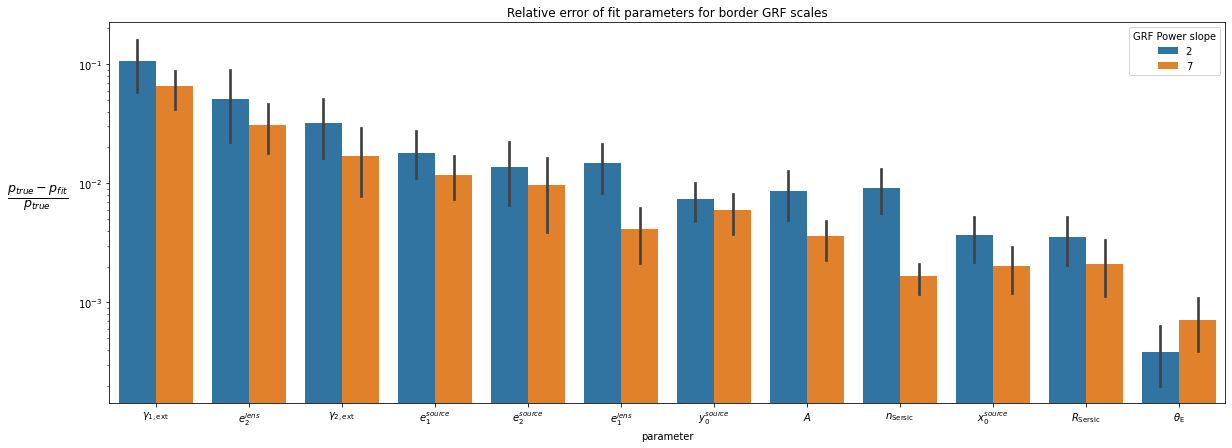

In [61]:
temp=df_deviation.drop(np.where(np.isinf(df_deviation['rel_error']))[0])
temp.loc[:,'rel_error']=np.abs(temp.loc[:,'rel_error'])

#Sort temp_df to get descending mean
mean_descending_ordering = temp.groupby('parameter').mean().sort_values('rel_error',ascending=False).index.to_numpy()
temp['parameter']=pd.Categorical(temp['parameter'], categories = mean_descending_ordering)
temp.sort_values('parameter',inplace=True)
temp.rename(columns={'Beta':'GRF Power slope'},inplace=True)

plt.figure(figsize=(20,7))
sns.barplot(data=temp,x='parameter',y='rel_error',hue='GRF Power slope')
plt.yscale('log')
plt.ylabel(r'$\frac{p_{true}-p_{fit}}{p_{true}}$',fontsize=FS,rotation=0,labelpad=40)
plt.title('Relative error of fit parameters for border GRF scales')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


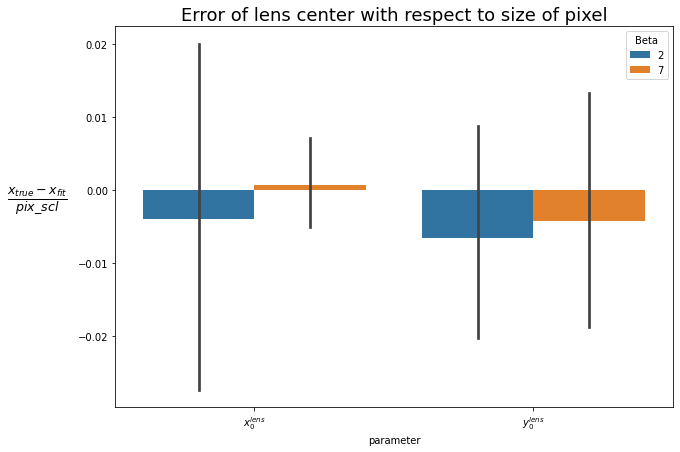

In [62]:
pix_scl=GRF_class.Lens_Source_model.kwargs_pixel['transform_pix2angle'][0,0]
mask_x_lens=np.isin(df_deviation.parameter,['$x_{0}^{lens}}$','$y_{0}^{lens}$'])
temp=df_deviation[mask_x_lens]
temp['rel_error']=(df_deviation['true_value']-df_deviation['fit_value'])/pix_scl


plt.figure(figsize=(10,7))
sns.barplot(data=temp,x='parameter',y='rel_error',hue='Beta')
plt.ylabel(r'$\frac{x_{true}-x_{fit}}{pix\_scl}$',fontsize=FS,rotation=0,labelpad=40)
plt.title('Error of lens center with respect to size of pixel',fontsize=FS)
plt.show()

Maybe relying on parameters $\vec{p_1}=f(\vec{p},A_{0},\beta_{0}) + \delta f(\phi_{0})$ is not really valid criterium. After all we care about $\psi(\vec{p_1})-\psi(\vec{p_0})$ 

In [64]:
'''Fit_images=np.zeros((2,len(kwargs_final_array_LS),100,100))

for i in range(len(kwargs_final_array_LS)):
  lens_source_class=Lens_Source_model(kwargs_lens_mass_array=kwargs_final_array_LS[i]['kwargs_lens'],\
                                      kwargs_source_light_array=kwargs_final_array_LS[i]['kwargs_source'])
  Fit_images[0,i]=lens_source_class.get_lens_picture(picture_type='model')


  lens_source_class=Lens_Source_model(kwargs_lens_mass_array=kwargs_final_array_HS[i]['kwargs_lens'],\
                                      kwargs_source_light_array=kwargs_final_array_HS[i]['kwargs_source'])
  Fit_images[1,i]=lens_source_class.get_lens_picture(picture_type='model')
  
np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Fit_images_Var=1e-5.npy',Fit_images)
'''

Fit_images=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Fit_images_Var=1e-5.npy',allow_pickle=True)

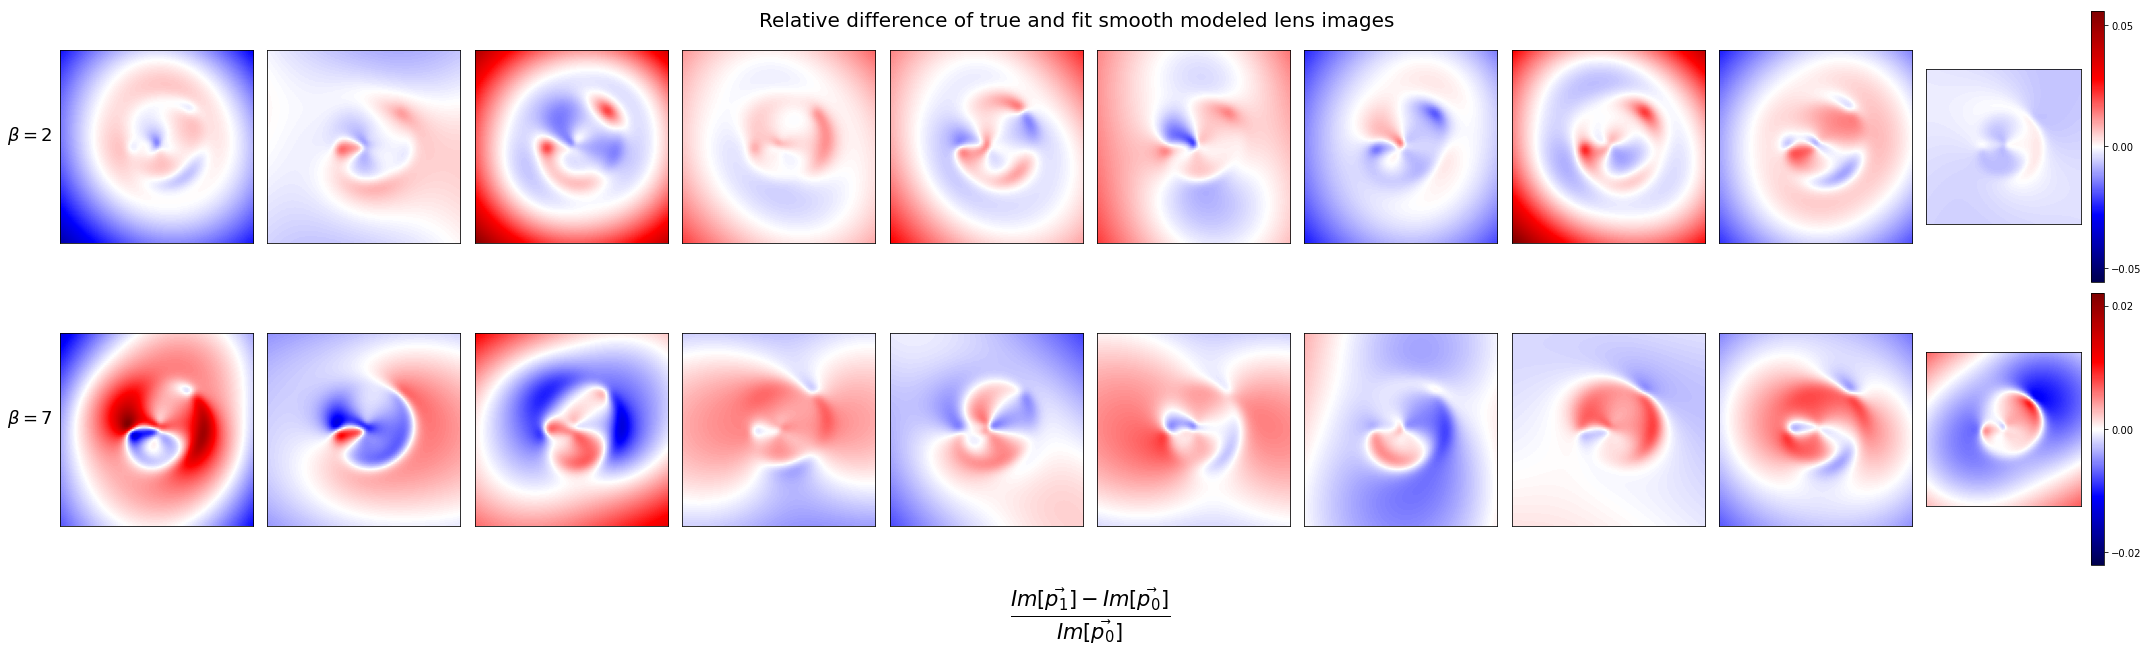

In [99]:


fig,ax=plt.subplots(2,len(kwargs_final_array_LS),figsize=(30,8),sharex=True)
model_resid=-Fit_images+GRF_class.get_lens_picture(picture_type='model',include_GRF=False)
model_resid/=GRF_class.get_lens_picture(picture_type='model',include_GRF=False)
abs_max_LS=np.abs(model_resid[0]).max()
abs_max_HS=np.abs(model_resid[1]).max()


for i in range(len(kwargs_final_array_LS)):
  im_LS=ax[0,i].imshow(model_resid[0,i],origin='lower',vmin=-abs_max_LS,vmax=abs_max_LS,cmap='seismic')
  im_HS=ax[1,i].imshow(model_resid[1,i],origin='lower',vmin=-abs_max_HS,vmax=abs_max_HS,cmap='seismic')
  

for i in range(2):
  for j in range(len(kwargs_final_array_LS)):
      ax[i,j].set_xticks([])
      ax[i,j].set_yticks([])

ax[0,0].set_ylabel(r'$\beta=2$',rotation=0, fontsize=FS,labelpad=30)
ax[1,0].set_ylabel(r'$\beta=7$',rotation=0, fontsize=FS,labelpad=30)

fig.suptitle('Relative difference of true and fit smooth modeled lens images',fontsize=20)
cbar=fig.colorbar(im_LS,ax=ax[0,-1])
cbar.ax.locator_params(nbins=4)
cbar=fig.colorbar(im_HS,ax=ax[1,-1])
cbar.ax.locator_params(nbins=4)

fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$\frac{Im[\vec{p_1}]-Im[\vec{p_0}]}{Im[\vec{p_0}]}$',fontsize=30)

plt.show()

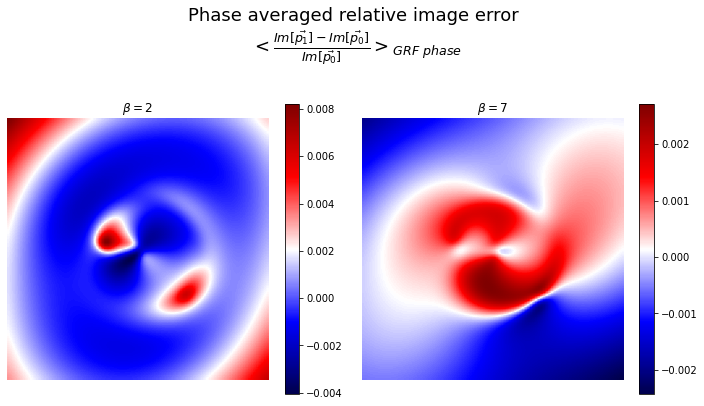

In [108]:
fig,ax=plt.subplots(1,2,figsize=(10,7))
Betas=[Beta_LS,Beta_HS]
cbar_loc=['left','right']
im_arr=[]

for i in range(2):
  im=ax[i].imshow(model_resid[i].mean(axis=0),cmap='seismic')
  im_arr+=[im]
  ax[i].axis('off')
  ax[i].set_title(r'$\beta=$'+'{:.0f}'.format(Betas[i]))

for i in range(2):
  fig.colorbar(im_arr[i],ax=ax[i],shrink=0.6)

#fig.colorbar(im_arr[1],ax=ax[1])
fig.suptitle('Phase averaged relative image error \n'+\
             r'$<\frac{Im[\vec{p_1}]-Im[\vec{p_0}]}{Im[\vec{p_0}]}>_{GRF \ phase}$',fontsize=18)
fig.tight_layout()

plt.show()

# Hypothesis 2)Big enough number M of phase realisations $\phi^{m}$

We want to find such number of phases M that M power spectra would reflect general behaviour of the residuals independent of the particular phase realisation. In math language it would be:  

$M: \quad  <PS\{res^{i,j,m}_{1}\}>_{m \in [0,M]} \quad \approx  \quad <PS\{res^{i,j,m}_{1}\}>_{m \in [0,\infty]}$

In [113]:
def Radial_profile(image,q=1,x0=None,y0=None,phi=0):
    if x0 is None or y0 is None:
        x0=image.shape[1]/2
        y0=image.shape[0]/2


    R_max=np.min(image.shape)//2
    radial_profile=np.zeros(R_max)
    counter=np.zeros(R_max)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            R=np.sqrt(np.power((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi),2)+
                np.power((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi),2)/np.power(q,2))
            if(R<R_max):
                radial_profile[int(R)]+=image[y,x]
                counter[int(R)]+=1

    mask_nan=(counter==0)
    counter[mask_nan]=np.nan
    radial_profile=radial_profile/counter
    #radial_profile[mask_nan]=0

    #Radial profile is average Flux in a ring of radius R
    return radial_profile

In [117]:
'''True_residuals=np.zeros_like(Fit_images)
True_residuals_spectra=np.zeros_like(True_residuals)

for i in tqdm(range(len(kwargs_final_array_LS))):
  GRF_class.Lens_Source_model.random_seed=random_seeds[i]
  GRF_class.Change_Power_Spectrum(Variance=GRF_Variance,Power_slope=Beta_LS)
  True_residuals[0,i]=GRF_class.get_lens_picture(picture_type='model')-Fit_images[0,i]
  masked_residual=np.where(mask,True_residuals[0,i],0)
  spectrum=np.fft.fft2(masked_residual)
  True_residuals_spectra[0,i]=np.roll(np.abs(spectrum)**2,GRF_class.Lens_Source_model.kwargs_pixel['nx']//2,axis=(0,1))


  GRF_class.Change_Power_Spectrum(Variance=GRF_Variance,Power_slope=Beta_HS)
  True_residuals[1,i]=GRF_class.get_lens_picture(picture_type='model')-Fit_images[1,i]

  masked_residual=np.where(mask,True_residuals[1,i],0)
  spectrum=np.fft.fft2(masked_residual)
  True_residuals_spectra[1,i]=np.roll(np.abs(spectrum)**2,GRF_class.Lens_Source_model.kwargs_pixel['nx']//2,axis=(0,1))

Radially_averaged_spectra=np.zeros((2,True_residuals_spectra.shape[1],True_residuals_spectra.shape[-1]//2))

for i in range(2):
  for j in tqdm(range(len(kwargs_final_array_LS))):
    Radially_averaged_spectra[i,j]=Radial_profile(True_residuals_spectra[i,j])'''

"True_residuals=np.zeros_like(Fit_images)\nTrue_residuals_spectra=np.zeros_like(True_residuals)\n\nfor i in tqdm(range(len(kwargs_final_array_LS))):\n  GRF_class.Lens_Source_model.random_seed=random_seeds[i]\n  GRF_class.Change_Power_Spectrum(Variance=GRF_Variance,Power_slope=Beta_LS)\n  True_residuals[0,i]=GRF_class.get_lens_picture(picture_type='model')-Fit_images[0,i]\n  masked_residual=np.where(mask,True_residuals[0,i],0)\n  spectrum=np.fft.fft2(masked_residual)\n  True_residuals_spectra[0,i]=np.roll(np.abs(spectrum)**2,GRF_class.Lens_Source_model.kwargs_pixel['nx']//2,axis=(0,1))\n\n\n  GRF_class.Change_Power_Spectrum(Variance=GRF_Variance,Power_slope=Beta_HS)\n  True_residuals[1,i]=GRF_class.get_lens_picture(picture_type='model')-Fit_images[1,i]\n\n  masked_residual=np.where(mask,True_residuals[1,i],0)\n  spectrum=np.fft.fft2(masked_residual)\n  True_residuals_spectra[1,i]=np.roll(np.abs(spectrum)**2,GRF_class.Lens_Source_model.kwargs_pixel['nx']//2,axis=(0,1))\n\nRadially_averag

In [118]:
'''np.save(Folder+'/Data/Phase_averaging/Hypothesis1/Res_spectra_rad_avg_Var=1e-5.npy',Radially_averaged_spectra)
'''

Radially_averaged_spectra=np.load(Folder+'/Data/Phase_averaging/Hypothesis1/Res_spectra_rad_avg_Var=1e-5.npy',allow_pickle=True)

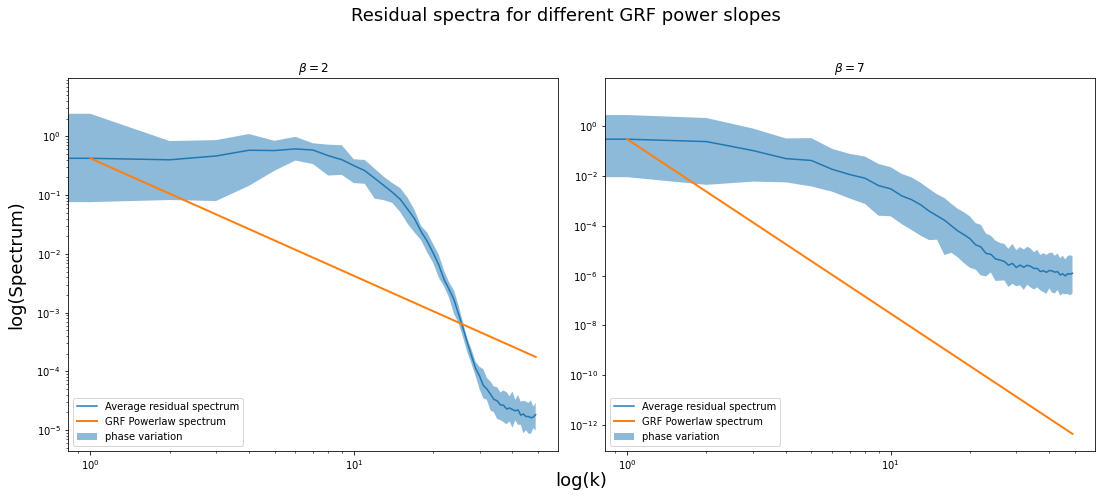

In [180]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
Betas=[Beta_LS,Beta_HS]
array_len=Radially_averaged_spectra.shape[-1]
Power_spectrum=np.zeros((2,array_len-1))
k=np.arange(array_len).astype(float)


for i in range(2):
  #Plot mean curve and border curves
  ax[i].plot(Radially_averaged_spectra[i].mean(axis=0),label='Average residual spectrum')
  ax[i].fill_between(x=np.arange(array_len),y1=Radially_averaged_spectra[i].max(axis=0),y2=Radially_averaged_spectra[i].min(axis=0),\
                     alpha=0.5,label='phase variation')

  #Plot GRF power spectrum
  #Start from k[1] to avoid divergence in zero
  Power_spectrum[i]=np.power(k[1:],-Betas[i])
  #Normalize it to residual spectrum values
  Power_spectrum[i]*=Radially_averaged_spectra[i].mean(axis=0)[1]/Power_spectrum[i][0]
  ax[i].plot(k[1:],Power_spectrum[i],linewidth=2,label='GRF Powerlaw spectrum')



ax[0].set_title(r'$\beta=2$')
ax[1].set_title(r'$\beta=7$')
for i in range(2):
  ax[i].set_yticks([])
  ax[i].set_yscale('log')
  ax[i].set_xscale('log')
  ax[i].legend(loc='lower left')
  

fig.suptitle('Residual spectra for different GRF power slopes',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=FS)
plt.ylabel('log(Spectrum)',fontsize=FS,labelpad=20)
plt.show()

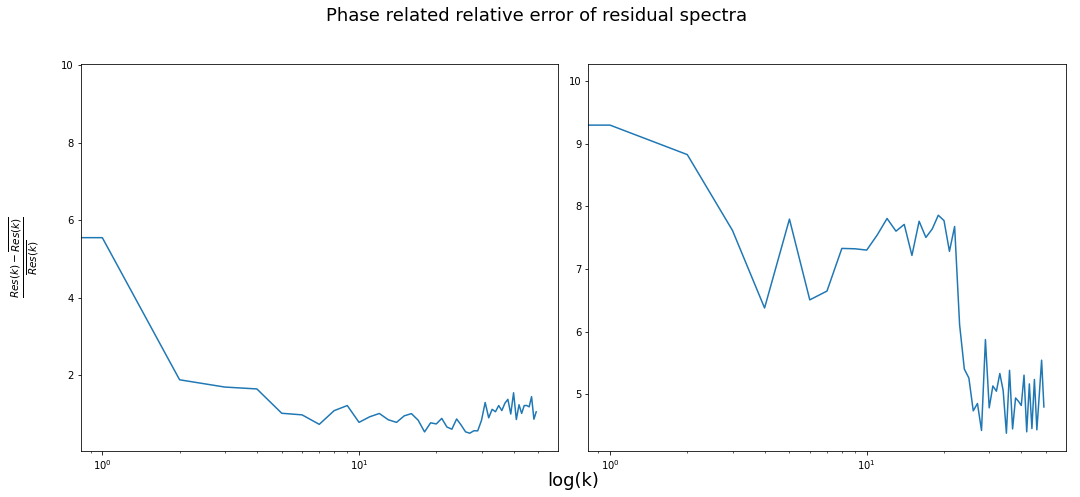

In [194]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
Betas=[Beta_LS,Beta_HS]
array_len=Radially_averaged_spectra.shape[-1]
Power_spectrum=np.zeros((2,array_len-1))
k=np.arange(array_len).astype(float)


#Bottom row with phase impact on spectrum
relative_error=[]
#Top row with spectrum
for i in range(2):
  err=Radially_averaged_spectra[i].max(axis=0)-Radially_averaged_spectra[i].min(axis=0)
  relative_error+=[err/Radially_averaged_spectra[i].mean(axis=0)]
  ax[i].plot(np.arange(array_len),relative_error[i])


  #ax[0,i].set_yticks([])
  #ax[i].set_yscale('log')
  ax[i].set_xscale('log')

ax[0].set_ylabel(r'$\frac{Res(k)-\overline{Res(k)}}{\overline{Res(k)}}$',fontsize=15,labelpad=20)

fig.suptitle('Phase related relative error of residual spectra',fontsize=FS,y=1.1)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('log(k)',fontsize=FS)
plt.show()

So the error is always something like an order of magnitude.  

Anyway it would be good to make plot of error depending on M (number of phase realisations) and pick such M when it would start to get into saturation.


Probably it also makes sense to use loss in a form of chi_sq, specifically we define Power spectrum averaged over phases, and define its variance that refers to phase:  
$PS\{res^{i,j}_{1}\}=<PS\{res^{i,j,m}_{1}\}>_m$  
$\sigma^2_{i,j}=\sum_{m}  (PS\{res^{i,j,m}_{1}\} - PS\{res^{i,j}_{1}\})^2 $ 

$\mathcal{L}^{ij}=\frac{( \ PS\{res_{0}\} - PS\{res^{i,j}_{1}\} \ )^2}
{\sigma^2_{i,j}}$

In [165]:
err_up

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])